In [15]:
import os
import sys
import gc
import glob
import time
from os import listdir

import tqdm
from typing import Dict

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")


import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff

#supress warnings
import warnings
warnings.filterwarnings("ignore")

from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [20]:
folder_path = '/Users/hesu/Documents/data/riiid-test-answer-prediction/'
train_csv = folder_path + 'train.csv'
test_csv =  folder_path + 'example_test.csv'
lec_csv  =  folder_path + 'lectures.csv'
que_csv =   folder_path + 'questions.csv'
sample_csv =    folder_path + 'example_sample_submission.csv'

data_types_dict = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
     'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float16',
    'prior_question_had_explanation': 'boolean'
}

In [34]:
train_df = pd.read_csv(train_csv, 
                       nrows=1000)

train_df["prior_question_had_explanation"].apply(bool)

0       True
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
970     True
971     True
972     True
973     True
974     True
975     True
976     True
977     True
978     True
979     True
980     True
981     True
982     True
983     True
984     True
985     True
986     True
987     True
988     True
989     True
990     True
991     True
992     True
993     True
994     True
995     True
996     True
997     True
998     True
999     True
Name: prior_question_had_explanation, Length: 1000, dtype: bool

In [35]:
type(train_df["prior_question_had_explanation"][1])
type(train_df["task_container_id"][1])

numpy.int64

In [36]:
train_df.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
row_id                            1000 non-null int64
timestamp                         1000 non-null int64
user_id                           1000 non-null int64
content_id                        1000 non-null int64
content_type_id                   1000 non-null int64
task_container_id                 1000 non-null int64
user_answer                       1000 non-null int64
answered_correctly                1000 non-null int64
prior_question_elapsed_time       974 non-null float64
prior_question_had_explanation    992 non-null object
dtypes: float64(1), int64(8), object(1)
memory usage: 78.2+ KB


In [40]:
def convert_bool(col): 
    if str(col) == "true": 
       return True 
    elif str(col) == "false": 
       return False 

df = pd.read_csv(train_csv,nrows=1000, converters={"prior_question_had_explanation": lambda x:convert_bool(x)})

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
row_id                            1000 non-null int64
timestamp                         1000 non-null int64
user_id                           1000 non-null int64
content_id                        1000 non-null int64
content_type_id                   1000 non-null int64
task_container_id                 1000 non-null int64
user_answer                       1000 non-null int64
answered_correctly                1000 non-null int64
prior_question_elapsed_time       974 non-null float64
prior_question_had_explanation    0 non-null object
dtypes: float64(1), int64(8), object(1)
memory usage: 78.2+ KB


In [42]:
train_df.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,974.000000
mean,499.500000,5.922425e+09,10257.714000,5514.763000,0.018000,93.898000,1.377000,0.602000,28787.718686
std,288.819436,6.384469e+09,4138.098385,4424.997707,0.133018,81.539612,1.220804,0.525235,18079.311312
min,0.000000,0.000000e+00,115.000000,2.000000,0.000000,0.000000,-1.000000,-1.000000,2000.000000
25%,249.750000,3.002659e+08,8623.000000,1368.250000,0.000000,31.750000,0.000000,0.000000,18000.000000
50%,499.500000,3.265900e+09,12741.000000,4802.500000,0.000000,72.000000,1.000000,1.000000,24000.000000
75%,749.250000,1.484871e+10,13134.000000,8518.500000,0.000000,122.250000,3.000000,1.000000,32000.000000
max,999.000000,1.509249e+10,13134.000000,30207.000000,1.000000,298.000000,3.000000,1.000000,201000.000000


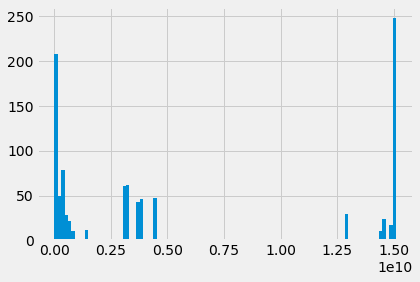

In [43]:
train_df['timestamp'].hist(bins = 100)

In [44]:
grouped_by_user_df = train_df.groupby('user_id')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cce9748>]],
      dtype=object)

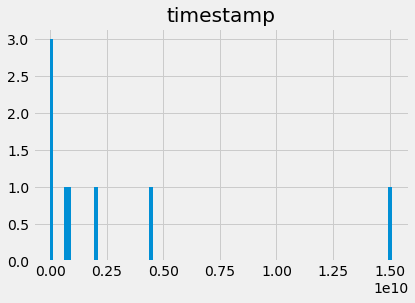

In [45]:
grouped_by_user_df.agg({'timestamp': 'max'}).hist(bins = 100)